In [52]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import sys
sys.path.append('../../py/')

from cosmoSim import cosmoSim

In [53]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams['font.size']=10

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rc('text', usetex=True)

ALPHA=0.8

FIG_HEIGHT = 11 / 2
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

snap_ranges = [
    [5, 4],
    [3, 2]
    ]

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'

linestyles = [
    'solid',
    (0, (3, 1, 1, 1)),
    'dashed'
]

text_labels = [
    "3 Mpc $h^{-1}$",
    "5 Mpc $h^{-1}$",
    "10 Mpc $h^{-1}$"
]

colors = [
    'tab:orange',
    'tab:purple',
    'tab:brown'
]

In [54]:
outpath = '../../plots/plots_L3N256_boxes/grid/'

try:
    os.mkdir(outpath)
except:
    print(f'{outpath} already exists!')


box_CDM_HY_runs = [
        'run_CDM_L3N256_HY_dir_0',
        'run_CDM_L5N256_HY',
        'run_CDM_L10N256_HY'
        ]


box_tcDM_HY_runs = [
        'run_2cDM_L3N256_HY_power00_sigma1_dir_0',
        'run_2cDM_L5N256_HY_power00_sigma1',
        'run_2cDM_L10N256_HY_power00_sigma1',
        ]

res_CDM_HY_runs = [
        'run_CDM_L3N128_HY',
        'run_CDM_L3N256_HY_dir_0',
        'run_CDM_L3N512_HY'
]

res_tcDM_HY_runs = [
        'run_2cDM_L3N128_HY_power00_sigma1',
        'run_2cDM_L3N256_HY_power00_sigma1_dir_0',
        'run_2cDM_L3N512_HY_power00_sigma1'
]

../../plots/plots_L3N256_boxes/grid/ already exists!


In [55]:
CDM_runs = box_CDM_HY_runs
tcDM_runs = box_tcDM_HY_runs

In [56]:
def wnumber2wlength(k):
    return 1/k
def wlength2wnumber(l):
    return 1/l    

In [57]:
def profile_inner(fig, axes, function, zz, m2m2, ratio=False):
    if function == 'mass':
        fig.supxlabel("Halo Mass ($M_{\odot}$)")
        if ratio:
            fig.supylabel("$N_{2cDM}\\left(>M\\right)/N_{CDM}\\left(>M\\right)$")
        else:
            fig.supylabel("$N\\left(>M\\right)$")
    elif function == 'velocity':
        fig.supxlabel("$V_{max}$ [km s$^{-1}$]")
        if ratio:
            fig.supylabel("$N_{2cDM}\\left(>V\\right)/N_{CDM}\\left(>V\\right)$")
        else:
            fig.supylabel("$N\\left(>V\\right)$")

    ax = axes[-1, -1]
    #print(ax.get_xticks())

    if function == 'mass': ax.set_xticks(ax.get_xticks()[3:])

    if zz:
        ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
    if m2m2:
        ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)

    if not ratio: ax.plot([],[], label='CDM', color=cdm_color)

    for i in range(len(text_labels)):
        c = 'k' if not ratio else colors[i]
        ax.plot([],[], label=text_labels[i], color=c, linestyle=linestyles[i])

    # ax.plot([],[], label='Hydro', color='k')
    # ax.plot([],[], label='N-Body', color='k', linestyle='dashed')
    ax.legend()

    if function == 'mass':
        for a in axes[:, -1]:
            a.set_xlim(10**6, 10**12)

    fig.tight_layout()

def the_profile_plotting(redshift_ranges, function, CDM_runs, tcDM_runs, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]
            for k, run_n in enumerate(CDM_runs):
                run = cosmoSim(run_n)
                if function == 'mass':
                    bins, counts = run.load_mass_profile(redshift)
                elif function == 'velocity':
                    bins, counts = run.load_vel_profile(redshift)
                else:
                    raise Exception('No function specified!')
                ax[j].plot(bins, counts, alpha=ALPHA, color=cdm_color, linestyle=linestyles[k])
            for k, run_n in enumerate(tcDM_runs):
                run = cosmoSim(run_n)
                if function == 'mass':
                    bins, counts = run.load_mass_profile(redshift)
                elif function == 'velocity':
                    bins, counts = run.load_vel_profile(redshift)
                else:
                    raise Exception('No function specified!')
                ax[j].plot(bins, counts, alpha=ALPHA, color=zz_color, linestyle=linestyles[k])

            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_yscale("log")
                a.set_xscale("log")
                if function == 'mass':
                    a.set_xlim(10**6, 10**12)
                if function == 'velocity':
                    a.set_xlim(2, 7*10**2)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )
            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()
    profile_inner(fig, axes, function, zz, m2m2)
    fname = outpath + f'grid_{function}_profiles'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

def the_profile_ratio_plotting(redshift_ranges, function, CDM_runs, tcDM_runs, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]
            for k in range(len(CDM_runs)):
                cdm_run = cosmoSim(CDM_runs[k])
                tcdm_run = cosmoSim(tcDM_runs[k])
                if function == 'mass':
                    lims, interp = tcdm_run.interp_mass_profile(redshift)
                    clims, cinterp = cdm_run.interp_mass_profile(redshift)
                elif function == 'velocity':
                    lims, interp = tcdm_run.interp_vels_profile(redshift)
                    clims, cinterp = cdm_run.interp_vels_profile(redshift)
                else:
                    raise Exception('No function specified!')
                inf = clims[0] if clims[0] > lims[0] else lims[0]
                sup = clims[1] if clims[1] < lims[1] else lims[1]

                domain = np.geomspace(inf, sup, num=1000)
                samps = interp(domain)
                csamps = cinterp(domain)
                ax[j].plot(domain, samps/csamps, alpha=ALPHA, color=colors[k], linestyle=linestyles[k])

            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_xscale("log")
                if function == 'mass':
                    a.set_xlim(10**6, 10**12)
                if function == 'velocity':
                    a.set_xlim(2, 7*10**2)
                a.grid(True, which="both", ls="-")
                a.set_ylim(0, 1.5)
                a.set_aspect( 'auto', adjustable='box' )

            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    profile_inner(fig, axes, function, zz, m2m2, ratio=True)
    fname = outpath + f'grid_{function}_profiles_ratios'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

In [58]:
def power_spectra_inner(fig, axes, k_ny, zz, m2m2, ratio=False):
    fig.supxlabel('k [$h$ Mpc$^{-1}$]')
    if ratio:
        fig.supylabel('$P_{2cDM}/P_{CDM}$')
    else:
        fig.supylabel('$\Delta^{2}(k)$')

    for i, a in enumerate(axes[0]):
        sax = a.secondary_xaxis('top', functions=(wnumber2wlength, wlength2wnumber))

    sax.set_xticks([1e-3, 1e-2, 1e-1])

    ax = axes[0,0]
    topax = inset_axes(ax, # here using axis of the lowest plot
            height="5%",  # width = 5% of parent_bbox width
            width="200%",  # height : 340% good for a (4x4) Grid
            loc='upper right',
            bbox_to_anchor=(1.05, 0.3, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )
    topax.set_xticks([])
    topax.set_yticks([])
    [topax.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
    topax.patch.set_visible(False)
    topax.set_xlabel('$\lambda$ [Mpc $h^{-1}$]')
    topax.tick_params(top=True)

    ax = axes[-1, -1]

    ax.set_xticks([1e1, 1e2, 1e3])

    if zz:
        ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
    if m2m2:
        ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)

    if not ratio: ax.plot([],[], label='CDM', color=cdm_color)

    if ratio:
        ax.text(3*10**1, 0.2, '$k_{Nyquist}$')
    else:
        ax.text(3*10**1, 10**3 + 0.1*10**3, '$k_{Nyquist}$')

    for i in range(len(text_labels)):
        c = 'k' if not ratio else colors[i]
        ax.plot([],[], label=text_labels[i], color=c, linestyle=linestyles[i])
    ax.legend()

    fig.tight_layout()

def the_power_spectra_plotting(redshift_ranges, CDM_runs, tcDM_runs, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]
            for k, run_n in enumerate(CDM_runs):
                run = cosmoSim(run_n)

                bins, _, dk, k_ny = run.load_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026)

                ax[j].plot(bins, dk, alpha=ALPHA, color=cdm_color, linestyle=linestyles[k])
            for k, run_n in enumerate(tcDM_runs):
                run = cosmoSim(run_n)

                bins, _, dk, k_ny = run.load_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026)

                ax[j].plot(bins, dk, alpha=ALPHA, color=zz_color, linestyle=linestyles[k])

                ax[j].vlines(k_ny, 10**0, 10**18, colors='m', linestyles=linestyles[k])
            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_yscale("log")
                a.set_xscale("log")
                a.set_xlim(10**0, 10**3)
                a.set_ylim(10**0, 10**9 + 2*10**8)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )
            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    power_spectra_inner(fig, axes, k_ny, zz, m2m2)
    fname = outpath + f'grid_power_spectra'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

def the_power_spectra_ratio_plotting(redshift_ranges, CDM_runs, tcDM_runs, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]
            for k in range(len(CDM_runs)):
                cdm_run = cosmoSim(CDM_runs[k])
                tcdm_run = cosmoSim(tcDM_runs[k])
                _, _, cdk, _ = cdm_run.load_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026)
                bins, _, dk, k_ny = tcdm_run.load_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026)

                ax[j].plot(bins, dk/cdk, alpha=ALPHA, color=colors[k], linestyle=linestyles[k])
                ax[j].vlines(k_ny, -3, 3, colors='m', linestyles=linestyles[k])

            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_xscale('log')
                a.set_xlim(10**0, 10**3)
                a.set_ylim(0, 1.3)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )

            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    power_spectra_inner(fig, axes, k_ny, zz, m2m2, ratio=True)
    fname = outpath + f'grid_power_spectra_ratios'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

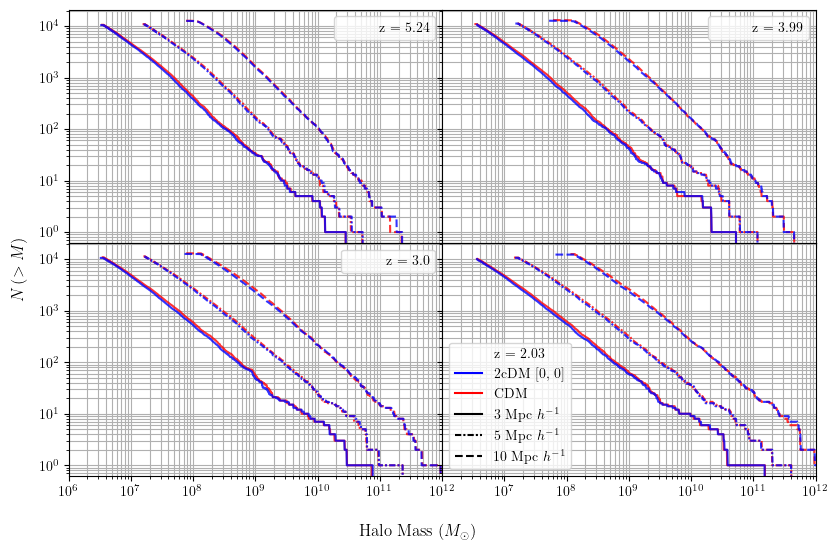

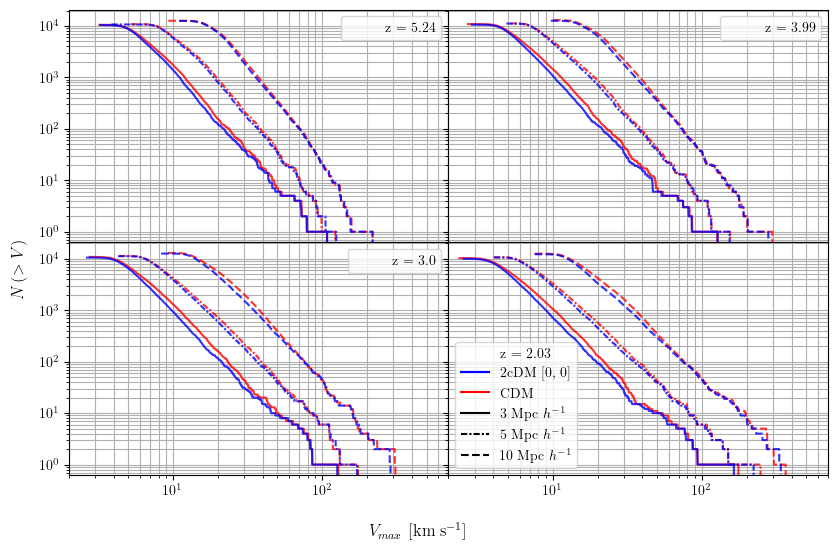

c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide


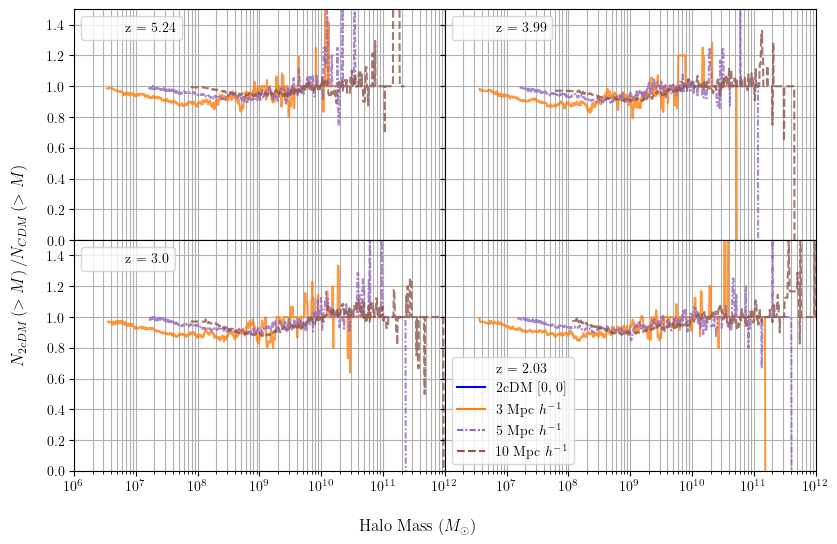

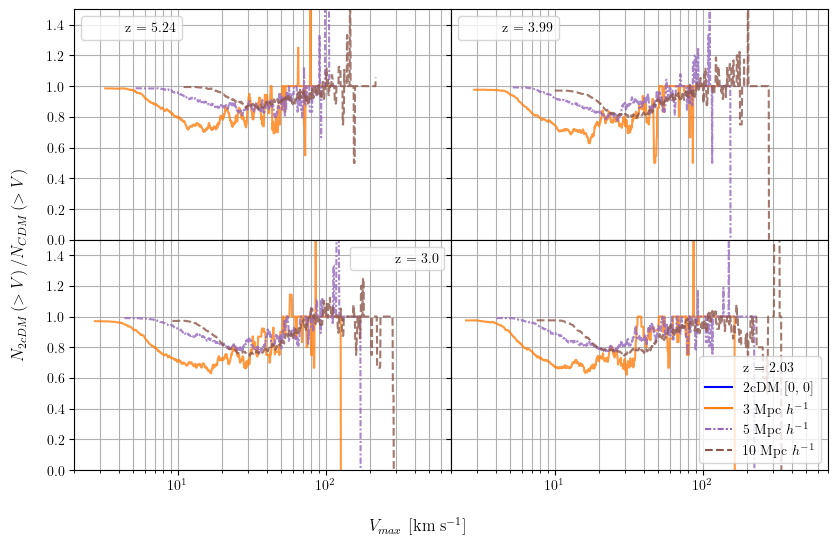

../../py\cosmoSim.py:219: UserWarning: No stars for redshift 5...
  warnings.warn(f'No stars for redshift {redshift}...')
c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


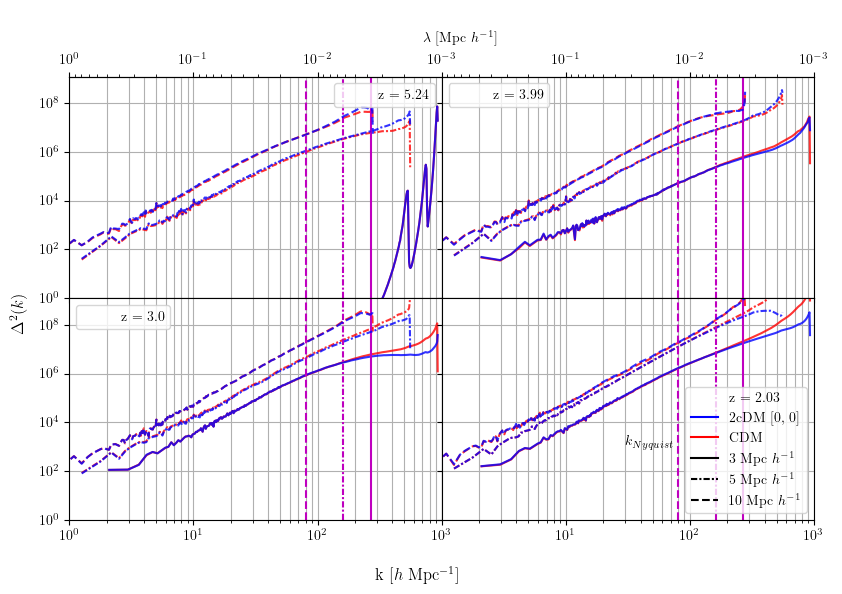

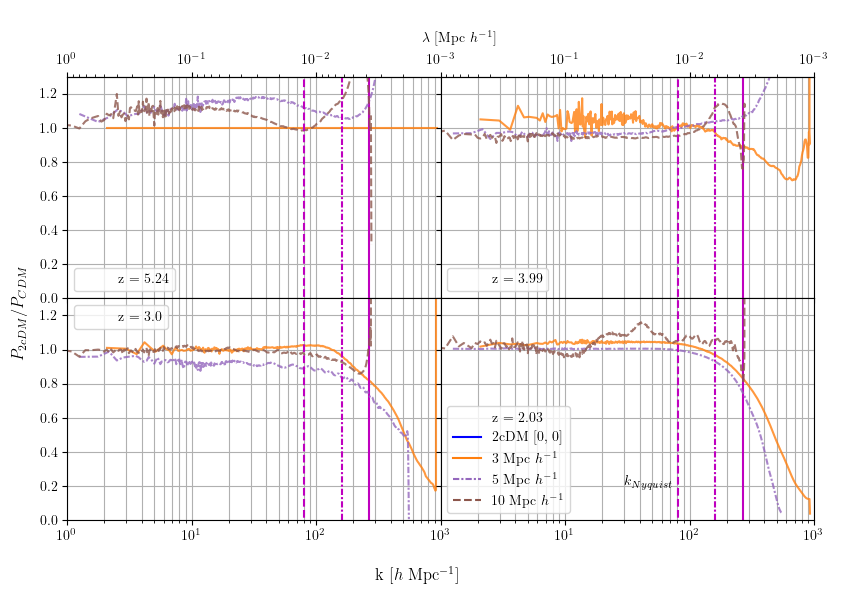

In [59]:
the_profile_plotting(snap_ranges, 'mass', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_plotting(snap_ranges, 'velocity', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_ratio_plotting(snap_ranges, 'mass', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_ratio_plotting(snap_ranges, 'velocity', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_power_spectra_plotting(snap_ranges, CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_power_spectra_ratio_plotting(snap_ranges, CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)

In [60]:
snap_ranges = [
    [5, 4],
    [3]
    ]

text_labels = [
    "128$^{3}$",
    "256$^{3}$",
    "512$^{3}$"
]

linestyles = [
    (0, (3, 1, 1, 1)),
    'solid',
    'dashed'
]

colors = [
    'tab:purple',
    'tab:orange',
    'tab:brown'
]

CDM_runs = res_CDM_HY_runs
tcDM_runs = res_tcDM_HY_runs

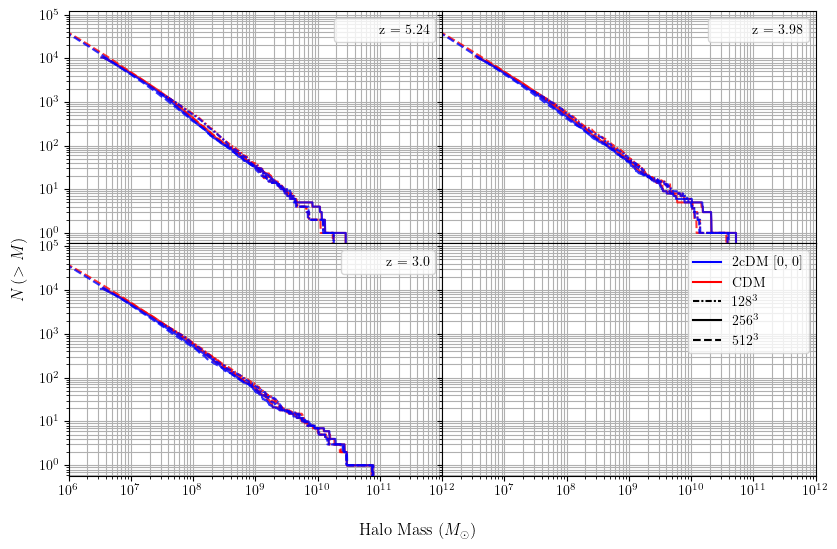

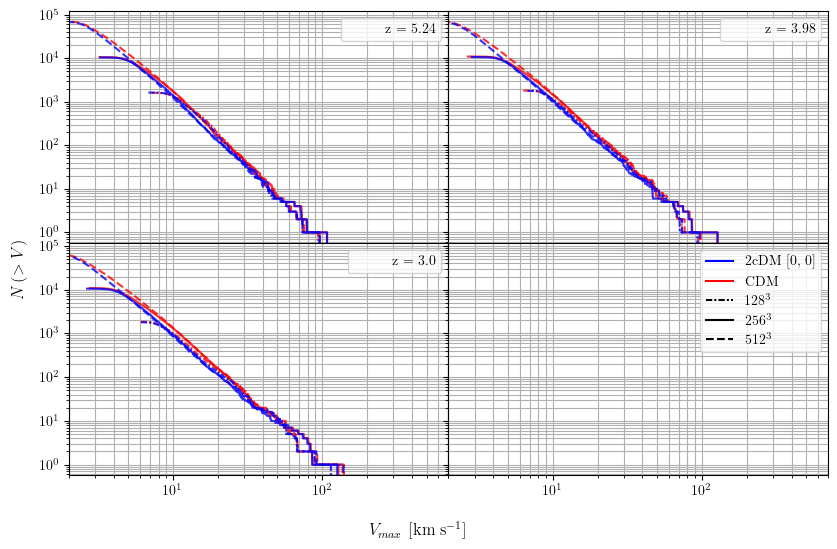

c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide


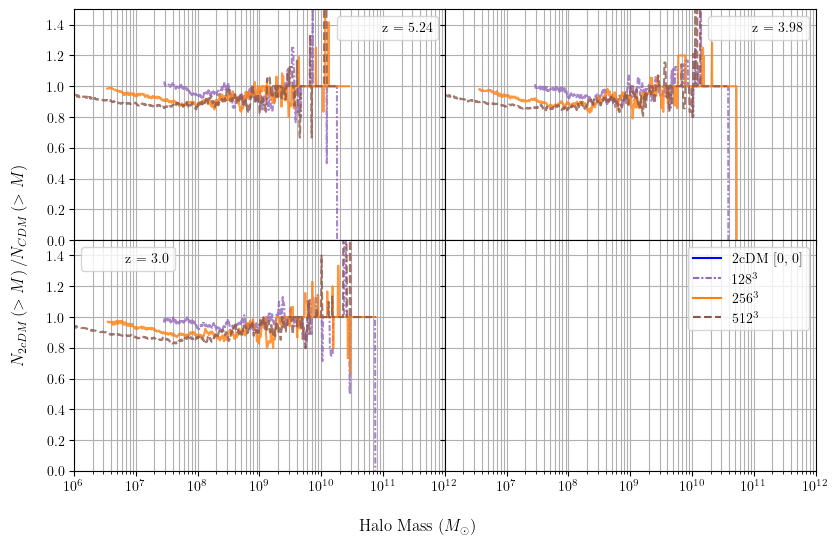

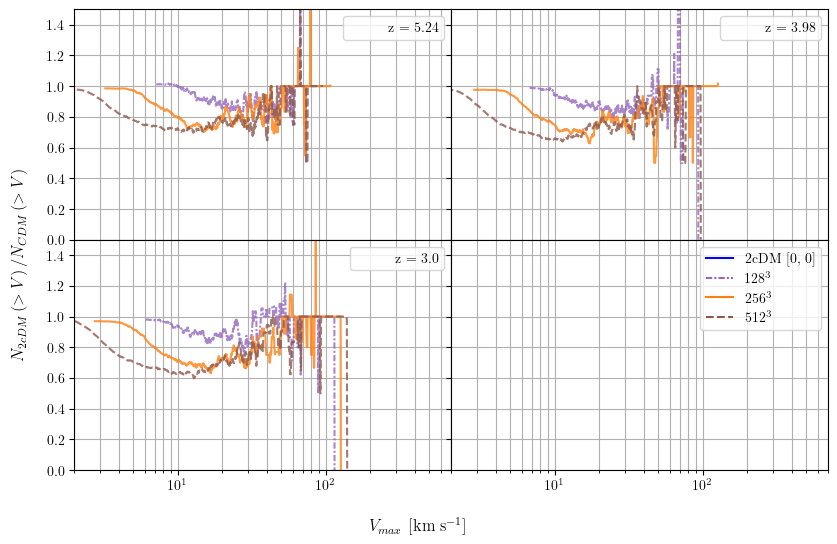

OSError: ../../data_prods/run_2cDM_L3N512_HY_power00_sigma1\PK-DM-snap_002.hdf5 not found.

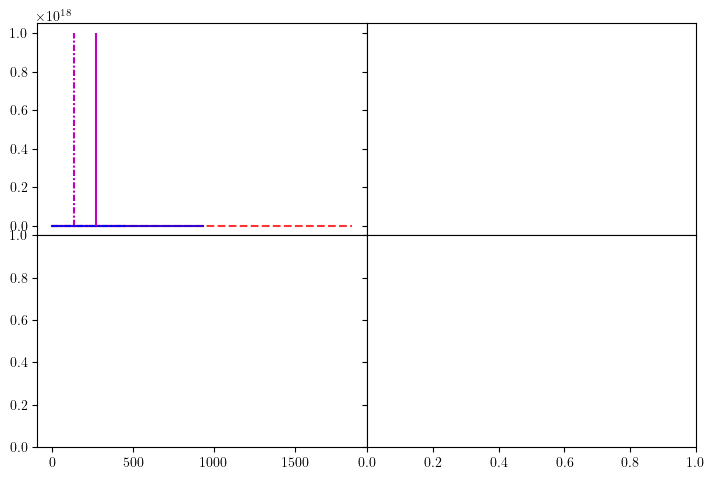

In [61]:
the_profile_plotting(snap_ranges, 'mass', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_plotting(snap_ranges, 'velocity', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_ratio_plotting(snap_ranges, 'mass', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_profile_ratio_plotting(snap_ranges, 'velocity', CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_power_spectra_plotting(snap_ranges, CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)
the_power_spectra_ratio_plotting(snap_ranges, CDM_runs, tcDM_runs, zz=True, m2m2=False, save=True)